<a href="https://colab.research.google.com/github/wissal9999999999999/MNIST_classification_GCN-/blob/main/GCN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 100.0 MB/s eta 0:00:00


In [ ]:

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.networks.nets import ResNet
from monai.networks.nets import EfficientNetBN
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2421
Numpy version: 1.25.2
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1070036ea3c30176fc82cfb15952387bed8b8a90
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visi

# setup

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp4sd_k6rg


In [ ]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:08, 7.12MB/s]                            

2024-05-28 02:15:04,336 - INFO - Downloaded: /tmp/tmp4sd_k6rg/MedNIST.tar.gz


2024-05-28 02:15:04,437 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-05-28 02:15:04,439 - INFO - Writing into directory: /tmp/tmp4sd_k6rg.


# Set deterministic training for reproducibility


In [ ]:
set_determinism(seed=0)


In [ ]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size
print(PIL.Image.open(image_files_list[0]))
print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

<PIL.JpegImagePlugin.JpegImageFile image mode=L size=64x64 at 0x7A07C0E45120>
Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


# Randomly pick images

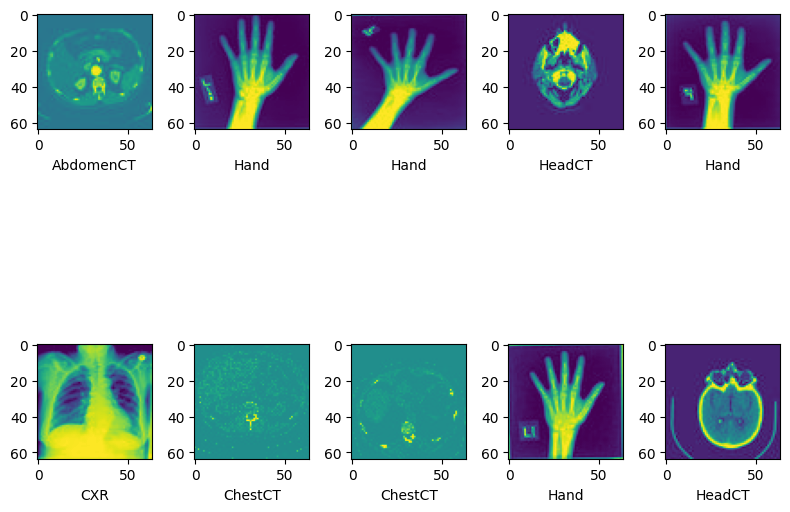

In [ ]:
plt.subplots(2, 5, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=10)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(2, 5, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# prepare data

In [ ]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


# Define MONAI transforms, Dataset and Dataloader to pre-process data


In [ ]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [ ]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

workers = 2
train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=300, num_workers=workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=300, num_workers=workers)

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist

In [ ]:
class GCNN(nn.Module):
    def __init__(self, img_size=64, pred_edge=False):
        super(GCNN, self).__init__()
        self.pred_edge = pred_edge
        N = img_size ** 2
        self.fc = nn.Linear(N, 6, bias=True)
        if pred_edge:
            col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
            coord = np.stack((col, row), axis=2).reshape(-1, 2)
            coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
            coord = torch.from_numpy(coord).float()  # 784,2
            coord = torch.cat((coord.unsqueeze(0).repeat(N, 1,  1),
                                    coord.unsqueeze(1).repeat(1, N, 1)), dim=2)
            #coord = torch.abs(coord[:, :, [0, 1]] - coord[:, :, [2, 3]]) # this should have worked
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64), # this can be a hyperparameter
                                              nn.ReLU(),
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('coord', coord)
        else:
            A = self.precompute_adjacency_images(img_size)
            self.register_buffer('A', A)


    @staticmethod
    def precompute_adjacency_images(img_size):
        col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
        coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
        dist = cdist(coord, coord)
        sigma = 0.05 * np.pi


        A = np.exp(- dist / sigma ** 2)
        print('WARNING: try squaring the dist to make it a Gaussian')

        A[A < 0.01] = 0
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        # print(A_hat[:10, :10])
        return A_hat

    def forward(self, x):
        B = x.size(0)
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.coord).squeeze()

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1),
                                 x.view(B, -1, 1)).view(B, -1))
        return self.fc(avg_neighbor_features)

In [ ]:
model = GCNN(pred_edge=True)


In [ ]:
print(sum(p.numel() for p in model.parameters()))


24967


# Define network and optimizer


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()
model.to(device)

GCNN_ECNN(
  (fc): Linear(in_features=4096, out_features=6, bias=True)
  (pred_edge_fc): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [ ]:
import time


In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for_time = []
    back_time = []
    for batch_data in train_loader:
        # print(batch_data[0].shape)
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        a = time.time()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        b = time.time()
        loss.backward()
        c = time.time()
        optimizer.step()
        d = time.time()
        for_time.append(b-a)
        #print("forward",sum(for_time)/len(for_time))
        epoch_loss += loss.item()
        back_time.append(c-b)
        # print("backward",sum(back_time)/len(back_time))

        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/157, train_loss: 182.3151
2/157, train_loss: 160.3539
3/157, train_loss: 158.5603
4/157, train_loss: 154.5571
5/157, train_loss: 108.8867
6/157, train_loss: 119.2121
7/157, train_loss: 96.6925
8/157, train_loss: 91.0074
9/157, train_loss: 85.5788
10/157, train_loss: 63.5094
11/157, train_loss: 62.7111
12/157, train_loss: 57.5479
13/157, train_loss: 45.2721
14/157, train_loss: 49.0041
15/157, train_loss: 40.9917
16/157, train_loss: 31.2274
17/157, train_loss: 24.5166
18/157, train_loss: 28.2559
19/157, train_loss: 25.9535
20/157, train_loss: 22.4776
21/157, train_loss: 17.0527
22/157, train_loss: 9.7241
23/157, train_loss: 12.6801
24/157, train_loss: 16.1283
25/157, train_loss: 20.9872
26/157, train_loss: 22.4023
27/157, train_loss: 21.9780
28/157, train_loss: 21.1454
29/157, train_loss: 20.2082
30/157, train_loss: 20.8199
31/157, train_loss: 17.0817
32/157, train_loss: 13.1494
33/157, train_loss: 10.9036
34/157, train_loss: 9.4403
35/157, train_loss: 8.7351
36/157, train_loss: 8.6394